In [1]:
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
import os, glob
import zipfile
import tensorflow as tf
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.optimizers import *
from keras import backend as K
from keras.metrics import MeanIoU, Accuracy

In [2]:
# unzip 2d images of lung CT
path = '2d_images.zip'
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('2d_images')
    
# unzip 2d masks of lung CT
path = '2d_masks.zip'
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('2d_masks')

In [3]:
# load tiff images
img_list = sorted(glob.glob('2d_images/*.tif'))
mask_list = sorted(glob.glob('2d_masks/*.tif'))

print(len(img_list), len(mask_list))

267 267


In [4]:
# create numpy array placeholder for pixels with 1 channel (grey scale)
IMG_SIZE = 256
x_data, y_data = np.empty((2, len(img_list), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
# ^ 1st arg: (# of numpy set(x_data, y_data), length of numpy set, height, width, color channel)

In [5]:
for i, img_path in enumerate(img_list):
    # load image
    img = imread(img_path)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    x_data[i] = img

# convert mask images to numpy arrays
for i, img_path in enumerate(mask_list):
    # load image
    img = imread(img_path)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    y_data[i] = img

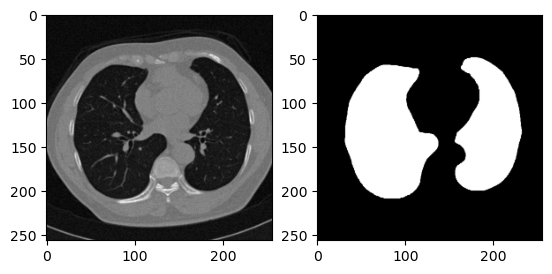

In [6]:
# scale image arrays
# scaling benefits learning process 
x_data /= 255
y_data /= 255

# display samples of image and mask in gray scale
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_data[50].squeeze(), cmap='gray')
ax[1].imshow(y_data[50].squeeze(), cmap='gray')
# ^ since imshow takes 2d array, 3d array is squeezed down to 2d by removing single dimensional entry

In [7]:
# split dataset into train and validation datasets with 20% test portion
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2)

print(x_train.shape)
print(x_val.shape)

(213, 256, 256, 1)
(54, 256, 256, 1)


In [13]:
def segnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Encoder
    enc_conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    enc_pool1 = MaxPooling2D((2, 2))(enc_conv1)

    enc_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(enc_pool1)
    enc_pool2 = MaxPooling2D((2, 2))(enc_conv2)

    enc_conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(enc_pool2)
    enc_pool3 = MaxPooling2D((2, 2))(enc_conv3)

    enc_conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(enc_pool3)
    enc_pool4 = MaxPooling2D((2, 2))(enc_conv4)

    enc_conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(enc_pool4)
    enc_pool5 = MaxPooling2D((2, 2))(enc_conv5)

    # Decoder
    dec_conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(enc_pool5)
    dec_upsamp5 = UpSampling2D((2, 2))(dec_conv5)

    dec_conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(dec_upsamp5)
    dec_upsamp4 = UpSampling2D((2, 2))(dec_conv4)

    dec_conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(dec_upsamp4)
    dec_upsamp3 = UpSampling2D((2, 2))(dec_conv3)

    dec_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(dec_upsamp3)
    dec_upsamp2 = UpSampling2D((2, 2))(dec_conv2)

    dec_conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(dec_upsamp2)
    dec_upsamp1 = UpSampling2D((2, 2))(dec_conv1)

    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(dec_upsamp1)

    model = Model(inputs, decoded)
    return model

# Define input shape and number of classes
input_shape = (256, 256, 1)
num_classes = 1  # Background and lung

# Create SegNet model
model = segnet(input_shape, num_classes)

# Compile the model with sparse categorical crossentropy
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


# Print model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 64)        1849

In [14]:
#train model
model_checkpoint = ModelCheckpoint('C:/Users/BIKRAMJOY CHATTERJEE/DL Project/segmentation weights/segnet_1.h5', monitor='loss', save_best_only=True)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=10, batch_size=4, callbacks=[model_checkpoint, callback])

Epoch 1/10
54/54 [==============================] - 13s 203ms/step - loss: 0.4870 - accuracy: 0.7410
Epoch 2/10
54/54 [==============================] - 12s 218ms/step - loss: 0.2713 - accuracy: 0.8694
Epoch 3/10
54/54 [==============================] - 11s 211ms/step - loss: 0.1994 - accuracy: 0.9008
Epoch 4/10
54/54 [==============================] - 10s 184ms/step - loss: 0.1553 - accuracy: 0.9221
Epoch 5/10
54/54 [==============================] - 12s 218ms/step - loss: 0.1191 - accuracy: 0.9361
Epoch 6/10
54/54 [==============================] - 13s 236ms/step - loss: 0.1079 - accuracy: 0.9405
Epoch 7/10
54/54 [==============================] - 10s 183ms/step - loss: 0.0994 - accuracy: 0.9429
Epoch 8/10
54/54 [==============================] - 11s 202ms/step - loss: 0.0943 - accuracy: 0.9449
Epoch 9/10
54/54 [==============================] - 12s 217ms/step - loss: 0.0861 - accuracy: 0.9476
Epoch 10/10
54/54 [==============================] - 14s 261ms/step - loss: 0.0828 - accura

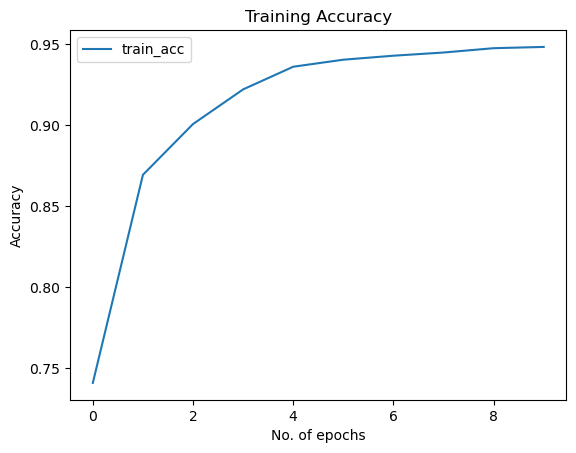

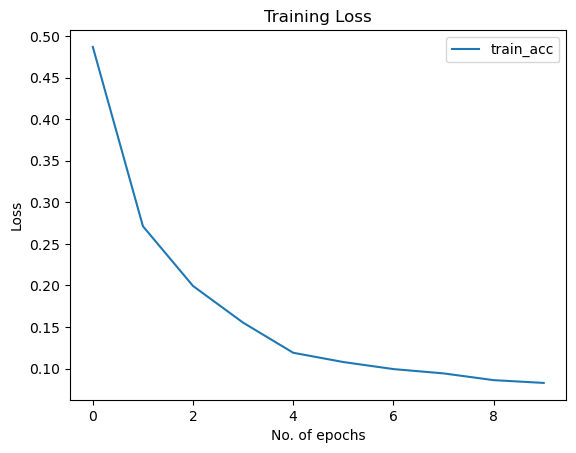

In [15]:
plt.plot(history.history['accuracy'], label = 'train_acc')
plt.legend()
plt.xlabel('No. of epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()

plt.plot(history.history['loss'], label = 'train_acc')
plt.legend()
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

2/2 [==============================] - 1s 235ms/step


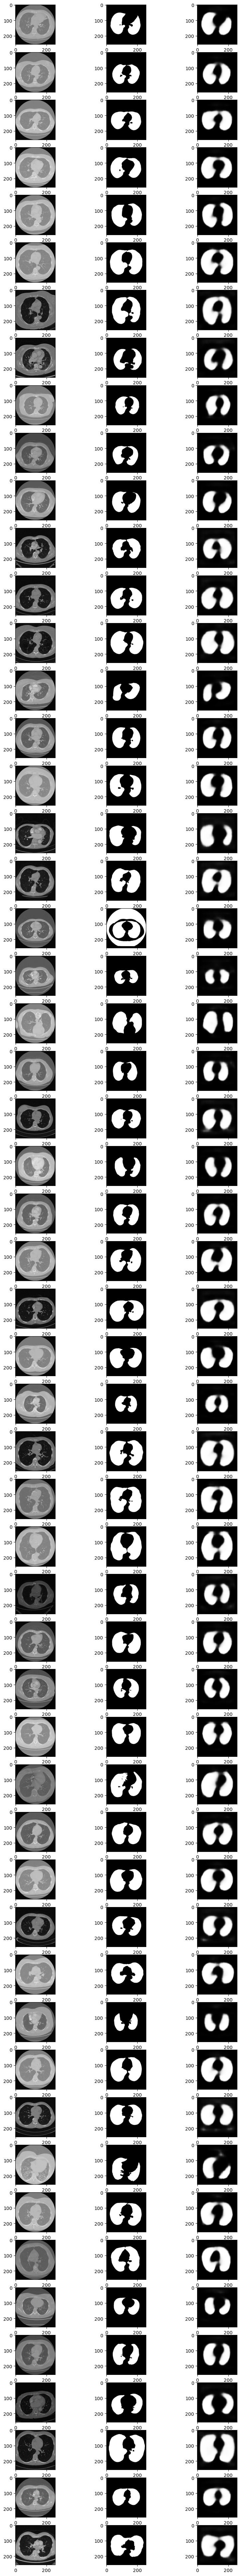

In [16]:
# predict segmentation
model.load_weights('C:/Users/BIKRAMJOY CHATTERJEE/DL Project/segmentation weights/segnet_1.h5')
y_pred = model.predict(x_val)

# show results
fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))
for i, pred in enumerate(y_pred):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')

mean IoU =  0.38686258
acc =  0.96418256
Dice Coefficient: 0.92763233
Classification Report : 
              precision    recall  f1-score   support

  Background       0.98      0.97      0.98   2676560
       Lungs       0.91      0.94      0.93    862384

    accuracy                           0.96   3538944
   macro avg       0.95      0.96      0.95   3538944
weighted avg       0.96      0.96      0.96   3538944

Cohen's Kappa =  0.9038417506768892


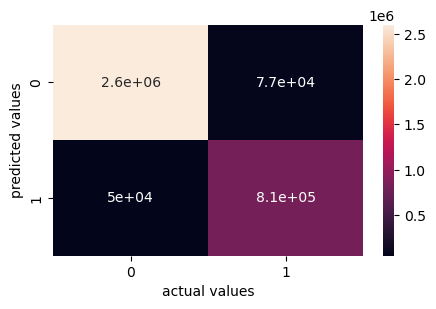

In [17]:
y_val_int = np.squeeze(y_val).astype(np.int32)
y_pred_int = np.squeeze(y_pred).astype(np.int32)

#MeanIoU
meaniou = MeanIoU(2)
meaniou.update_state(y_val_int, y_pred_int)
print('mean IoU = ', meaniou.result().numpy())
meaniou.reset_states()

y_val_binary = np.where(y_val > 0.5, 1, 0)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

#Accuracy
acc = Accuracy()
acc.update_state(y_val_binary, y_pred_binary)
print('acc = ', acc.result().numpy())
acc.reset_states()

#diceCoeff
intersection = tf.reduce_sum(tf.cast(y_val_binary * y_pred_binary, tf.float32))
sum_true = tf.reduce_sum(tf.cast(y_val_binary, tf.float32))
sum_pred = tf.reduce_sum(tf.cast(y_pred_binary, tf.float32))

dice_coeff = (2.0 * intersection + 1e-5) / (sum_true + sum_pred + 1e-5)
print("Dice Coefficient:", dice_coeff.numpy())

#Confusion matrix
cm = confusion_matrix(y_val_binary.flatten(), y_pred_binary.flatten(), labels=[0, 1])
import seaborn as sns
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot=True)
plt.xlabel('actual values')
plt.ylabel('predicted values')

#Classification report
cr = classification_report(y_val_binary.flatten(), y_pred_binary.flatten(), target_names=["Background", "Lungs"])
print("Classification Report : ")
print(cr)

#Cohen kappa score
k = cohen_kappa_score(y_val_binary.flatten(), y_pred_binary.flatten())
print("Cohen's Kappa = ", k)